In [1]:
import pandas as pd
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import zscore
from matplotlib.colors import LogNorm, Normalize
import os


In [2]:
FS = 4 # E4 sampling rate

DATA_FOLDER_PATH = '/media/bayesian-posterior/sdc/sensecode_data/'
DATA_FOLDER = os.fsencode(DATA_FOLDER_PATH)

DAYS_ARRAY = np.asarray([0.5, 1, 7])
FREQ_ARRAY = 1 / (DAYS_ARRAY * 24 * 60 * 60) # for morlet
FREQ_NAMES = ["{:.1f}".format(day)+' Day(s)' for day in DAYS_ARRAY]

PANDAS_RESAMPLE_RATE = "{:.2f}".format(1/4)+'S' # find missing samples (datetime)
PANDAS_RESAMPLE_RATE

'0.25S'

In [3]:
def plot_signal(df_eda,
                fs,
                label,
                ylim = None):
    
    plt.figure(figsize=(15, 5))
    
    t = df_eda.index.to_series()
    x = df_eda[label]
    xtick_freq = int(fs*60*60*24*7)
    
    plt.plot(range(len(t)), x, label = label)
    plt.legend(loc=1)
    plt.xticks(range(len(t))[::xtick_freq], t[::xtick_freq], rotation='vertical')

    if ylim is not None:
        plt.ylim(ylim)
    plt.xlabel('Date')
    plt.ylabel('EDA [uS]')
    plt.grid()

In [4]:
#this method implements the method from https://www.nature.com/articles/s41746-018-0074-9
def remove_artifacts_and_interpolate(df_eda, 
                     fs, 
                     pandas_resample_rate,
                                     clip_rate,
                                     interpolate_method = 'time',
                                     z_score = False, 
                     min_eda_value = 0.035, 
                     ratio_good_values = 0.9, 
                     window_size_in_seconds = 5, 
                     max_increased_eda_ratio = 1.2, 
                     max_decreased_eda_ratio = 0.9):

    # window_size = int(fs * window_size_in_seconds)
    # window_size_half_sec = int(fs * 0.5)
    # min_samples_above_threshold_in_each_window = ratio_good_values * window_size
    
    #######remove values below threshold
    # calculate rolling window sum
    # print('Calculating rolling sum')
    # df_eda['eda_above_min_threashold'] = 0
    # df_eda.loc[df_eda['eda'] > min_eda_value, 'eda_above_min_threashold'] = 1
    # df_eda['window_samples_above_threshold'] = df_eda['eda_above_min_threashold'].rolling('5s').sum()
    # # keep only values < max threshold
    # df_eda.loc[df_eda['window_samples_above_threshold'] > min_samples_above_threshold_5sec,'eda_above_min_threashold'] = np.nan
    # df_eda['eda_above_min_threashold'].fillna(method = 'bfill', inplace = True, limit = window_size_5sec )
    
    #######remove values with increasing slope > 10%
    # df_eda['eda_increased_from_previous_max'] = df_eda.eda.shift() 
    # df_eda['eda_increased_from_previous_max'] = df_eda['eda_increased_from_previous_max'].multiply(max_increased_eda_ratio)
    # df_eda['eda_increased_above_threshold'] = df_eda.eda - df_eda.eda_increased_from_previous_max
    # df_eda.loc[df_eda['eda_increased_above_threshold'] <= 0, 'eda_increased_above_threshold'] = np.nan
    # df_eda['eda_increased_above_threshold'].fillna(method='bfill', inplace=True, limit=window_size_half_sec)
    # df_eda['eda_increased_above_threshold'].fillna(method='ffill', inplace=True, limit=window_size_half_sec)
    
    #######remove values with decrease slope > 10%
    # df_eda['eda_decreased_from_previous_max'] = df_eda.eda.shift() 
    # df_eda['eda_decreased_from_previous_max'] = df_eda['eda_decreased_from_previous_max'].multiply(max_decreased_eda_ratio)
    # df_eda['eda_decreased_above_threshold'] = df_eda.eda - df_eda.eda_decreased_from_previous_max
    # df_eda.loc[df_eda['eda_decreased_above_threshold'] >= 0, 'eda_decreased_above_threshold'] = np.nan
    # df_eda['eda_decreased_above_threshold'].fillna(method='bfill', inplace=True, limit=window_size_half_sec)
    # df_eda['eda_decreased_above_threshold'].fillna(method='ffill', inplace=True, limit=window_size_half_sec)
    
    ####keep clean signal####
#     df_eda_clean_signal = df_eda.loc[(df_eda.eda_decreased_above_threshold.isna()) 
#                                      & (df_eda.eda_increased_above_threshold.isna()) 
#                                      & (df_eda.eda_above_min_threashold.isna())]
    
#     df_eda_clean_signal_eda_column = df_eda_clean_signal[['eda']]
#     print('finished slicing EDA column')
#     return df_eda_clean_signal_eda_column

    # df_eda = df_eda[(df_eda.eda_decreased_above_threshold.isna()) & (df_eda.eda_increased_above_threshold.isna())]
    # df_eda_without_artifacts = df_eda[['eda']].resample(pandas_resample_rate).mean()
    
    # df_eda_without_artifacts = df_eda.resample(pandas_resample_rate).interpolate(method=interpolate_method)
    
    df_eda_without_artifacts = df_eda.resample(pandas_resample_rate).mean()
    
    df_eda_without_artifacts['hour'] = df_eda_without_artifacts.index.to_series().apply(lambda x : x.hour)    
    df_eda_without_artifacts['eda'] = df_eda_without_artifacts.groupby('hour', group_keys=False)['eda'].apply(lambda x: x.fillna(x.mean()))
    
    # df_eda_without_artifacts.fillna(df_eda_without_artifacts['eda'].median(), inplace=True)
        
    if clip_rate > 0:
        upper_quantile = df_eda_without_artifacts['eda'].quantile(clip_rate)
        print('EDA upper quantile:', upper_quantile)
        df_eda_without_artifacts.loc[df_eda_without_artifacts['eda'] >= upper_quantile, 'eda'] = upper_quantile
    
    if z_score:
        print('z-scored')
        df_eda_without_artifacts['eda'] = zscore(df_eda_without_artifacts['eda'])
        

    # df_eda_without_artifacts.index = df_eda_without_artifacts.index.strftime('%m/%d/%Y')
    df_eda_without_artifacts.rename(columns={"eda": "interpolated_eda"}, inplace = True)
    return df_eda_without_artifacts

In [5]:
def apply_fir(eda: np.ndarray,
              fs,
              cutoff,
              filter_type, # bandpass, lowpass, highpass, bandstop
              transition_band,
              window) -> np.ndarray:
    
    if window == 'hann' or window == 'hamming' or window == 'bartlett':
        M = int(4 * fs / transition_band)
    elif window == 'blackman':
        M = int(6 * fs / transition_band)
    else:
        raise ValueError('Length estimation for this window not implemented')
        
    # print('Using ' + window + ' window for ' + filter_type + ' FIR filter.')
    h = signal.firwin(numtaps = M, 
                      cutoff = cutoff,
                      fs = fs,
                      pass_zero = filter_type,
                      window = window)
    
    eda = np.squeeze(eda)
    return signal.lfilter(h, [1.0], eda) 
    # return signal.filtfilt(h, [1.0], eda) # avoid phase shift of single filter

In [6]:
def morlet_wavelet(eda: np.ndarray, 
                   fs, 
                   freq_arr, 
                   w = 6):
    
    widths = w * fs / (2 * freq_arr * np.pi)
    cwtm = signal.cwt(eda, signal.morlet2, widths, w = w)
    
    return np.abs(cwtm)


In [7]:
def plot_morlet(df_eda, 
                freq_names, 
                freq_arr, 
                tick_freq):

    resampled_df = df_eda_without_artifacts[freq_names].resample(tick_freq).mean()
    cwtm = resampled_df.to_numpy().T # (len(freq_list), len(t))
    
    tick_freq_dict = {'T':60*24*7, 'H':24*7, 'D':7, 'W':1}
    t = resampled_df.index.to_series()
    xtick_freq = tick_freq_dict[tick_freq]
    
    fig, ax = plt.subplots(figsize=(15, 3)) 
    sns.heatmap(cwtm, 
                # center=0, 
                # cmap="vlag", 
                norm=LogNorm(vmin=cwtm.min(), vmax=cwtm.max()),
                ax=ax)
    
    ax.set_xticks(np.arange(len(t))[::xtick_freq], t[::xtick_freq], rotation='vertical')
    ax.set_yticks(np.arange(len(freq_names))+0.5, freq_names, rotation='horizontal')


/media/bayesian-posterior/sdc/sensecode_data/SP22_eda_worn_left.h5 SP22
EDA upper quantile: 3.407149970000006


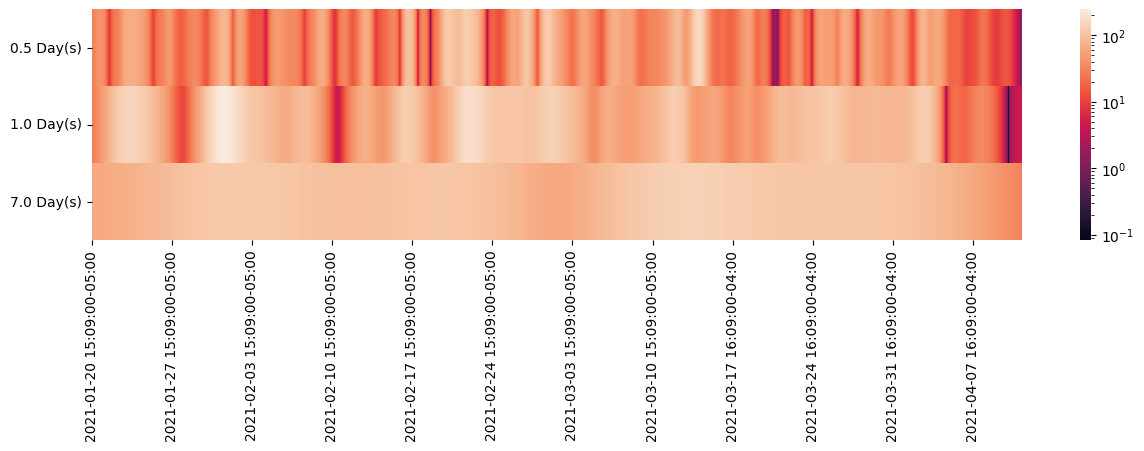

In [8]:
for file in os.listdir(DATA_FOLDER):
    
    filename = os.fsdecode(file)
    
    if filename.endswith("_worn_left.h5"):
        
        subject = filename.split('_')[0]
        eda_filepath = DATA_FOLDER_PATH+filename
        
        print(eda_filepath, subject)
        
        df_eda = pd.read_hdf(eda_filepath)
        
        # plot_signal(df_eda = df_eda, label = 'eda', fs = FS)
        df_eda_without_artifacts = remove_artifacts_and_interpolate(df_eda = df_eda, 
                                            fs = FS, 
                                            pandas_resample_rate = PANDAS_RESAMPLE_RATE, 
                                                           clip_rate = 0.995)
        
        # plot_signal(df_eda = df_eda_without_artifacts, label = 'eda', fs = FS)
        df_eda_without_artifacts['low_passed_eda'] = apply_fir(eda = df_eda_without_artifacts['interpolated_eda'].to_numpy(), 
                                     fs = FS, 
                                     cutoff = 1, 
                                     transition_band = 1,
                                     filter_type = 'lowpass', 
                                     window = 'hamming')
        
        cwt_matrix = morlet_wavelet(eda = df_eda_without_artifacts['low_passed_eda'].to_numpy(), 
                            fs = FS, 
                            freq_arr = FREQ_ARRAY)
        
        for idx, name in enumerate(FREQ_NAMES):
            df_eda_without_artifacts[name] = cwt_matrix[idx, :]
        
        cwt_h5_name = './cwt_data/' + subject + '_cwt.h5'
        df_eda_without_artifacts[FREQ_NAMES].to_hdf(cwt_h5_name, key='df', mode='w')
        
#         retrieved = pd.read_hdf(cwt_h5_name, 'df')
#         plot_morlet(df_eda = retrieved, 
#             freq_names = FREQ_NAMES, 
#             freq_arr = FREQ_ARRAY, 
#             tick_freq = 'T')
        
#         break